### Import Libraries & Global Constants

In [153]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
import statsmodels.api as sm
import joblib
from geopy.distance import geodesic
from fitter import Fitter, get_common_distributions

# Seed for reproducibility
SEED = 42

### Load Data

In [154]:
# Load the data from the CSV file
df = pd.read_csv('listings.csv')

In [155]:
#engineering
df['number_of_amenities'] = df['amenities'].apply(len)

## Data cleaning



In [156]:
irrelevant_columns = [ 'id', 'listing_url', 'scrape_id', 'last_scraped', 
                     'source', 'name', 'description', 'neighborhood_overview', 
                     'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 
                     'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                     'host_total_listings_count', 'host_verifications', 'neighbourhood', 
                     'neighbourhood_group_cleansed', 'property_type', 'bathrooms_text',  
                     'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'amenities',
                     'calendar_updated', 'calendar_last_scraped', 'number_of_reviews_l30d', 'first_review', 
                     'license',  'calculated_host_listings_count_entire_homes', 
                     'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
                     'host_response_time', 'has_availability', 'last_review', 'calculated_host_listings_count', 'neighbourhood_cleansed']

def remove_columns(df, columns_to_remove):
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    return df.drop(columns=existing_columns)

def clean_price(df):
    # First check that price is not already a numeric value
    if df['price'].dtype == np.float64:
        return df
    df_copy = df.copy()
    # Remove the commas and dollar signs from the price column
    df_copy['price'] = df_copy['price'].str.replace("$", "").str.replace(",", "").astype(float)
    return df_copy


def convert_boolean_columns(df):
    # Convert boolean columns to 0 and 1
    boolean_columns = df.select_dtypes(include='bool').columns
    df_copy = df.copy()
    for col in boolean_columns:
        df_copy[col] = df_copy[col].astype(int)

    # Needed since boolean data is inconsistent
    for col in df_copy.columns:
        if set(df_copy[col].unique()) == {'f', 't'}:
            df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
    return df_copy


def one_hot_encode_room_type(df):
    # One hot encode the room_type column
    # First check that the room_type column exists
    if 'room_type' not in df.columns:
        return df
    df_copy = pd.get_dummies(df, columns=['room_type'])
    return df_copy

def convert_percentage_to_decimal(percentage_str):
    try: 
        float(percentage_str)
        return 0
    except:    
        p = percentage_str.strip('%')
    
        return int(p) / 100

def clean_host_since(df):
    df_copy = df.copy()
    df_copy['host_since'] = pd.to_datetime(df_copy['host_since'])
    df_copy['host_since'] = (pd.to_datetime('today') - df_copy['host_since']).dt.days
    return df_copy

def fill_missing_values(df):
    df_copy = df.copy()
    #If type is numeric, fill with mean
    for col in df_copy.select_dtypes(include='number').columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Otherwise, if type is anything else, delete row
    df_copy = df_copy.dropna()

    return df_copy
    

def clean_percentage_columns(df):
    df['host_response_rate'] = df['host_response_rate'].apply(convert_percentage_to_decimal)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(convert_percentage_to_decimal)
    return df


In [157]:
################################################################################################

In [158]:
# merging the living conditions per neighbourhood to the dataframe
# https://tidsskriftet.no/en/2015/11/living-conditions-districts-oslo-and-poisonings-substances-abuse-treated-casualty-clinic
nbs = df['neighbourhood_cleansed'].unique()

lcs = [4.0, 8.2, 5.2, 7.3, 2.9, 7.8, 2.3,np.nan, 1.1, 1.7, 4.9, 6.1, 7.6, 6.1, np.nan, 8.4, 7.1]
#convert living conditions to higher is better
transformed_lcs = [(10 - num if not np.isnan(num) else num) for num in lcs[:11]] + lcs[11:]

dict = {
    'neighbourhood_cleansed': nbs,
    'living_conditions': transformed_lcs
}

living_conditions_df = pd.DataFrame(dict)


In [159]:
# merging
df_cleaned = pd.merge(df, living_conditions_df, on='neighbourhood_cleansed', how='left')

In [160]:
###################################################################################################

In [161]:
df_cleaned = remove_columns(df_cleaned, irrelevant_columns)
df_cleaned = clean_price(df_cleaned)
df_cleaned = fill_missing_values(df_cleaned)
df_cleaned = clean_host_since(df_cleaned)
df_cleaned = one_hot_encode_room_type(df_cleaned)
df_cleaned = convert_boolean_columns(df_cleaned)
df_cleaned = clean_percentage_columns(df_cleaned)

In [162]:
# Print all types of columns
pd.set_option("display.max_columns", None)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7656 entries, 0 to 10093
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_since                   7656 non-null   int64  
 1   host_response_rate           7656 non-null   float64
 2   host_acceptance_rate         7656 non-null   float64
 3   host_is_superhost            7656 non-null   int64  
 4   host_listings_count          7656 non-null   int64  
 5   host_has_profile_pic         7656 non-null   int64  
 6   host_identity_verified       7656 non-null   int64  
 7   latitude                     7656 non-null   float64
 8   longitude                    7656 non-null   float64
 9   accommodates                 7656 non-null   int64  
 10  bathrooms                    7656 non-null   float64
 11  bedrooms                     7656 non-null   float64
 12  beds                         7656 non-null   float64
 13  price                 

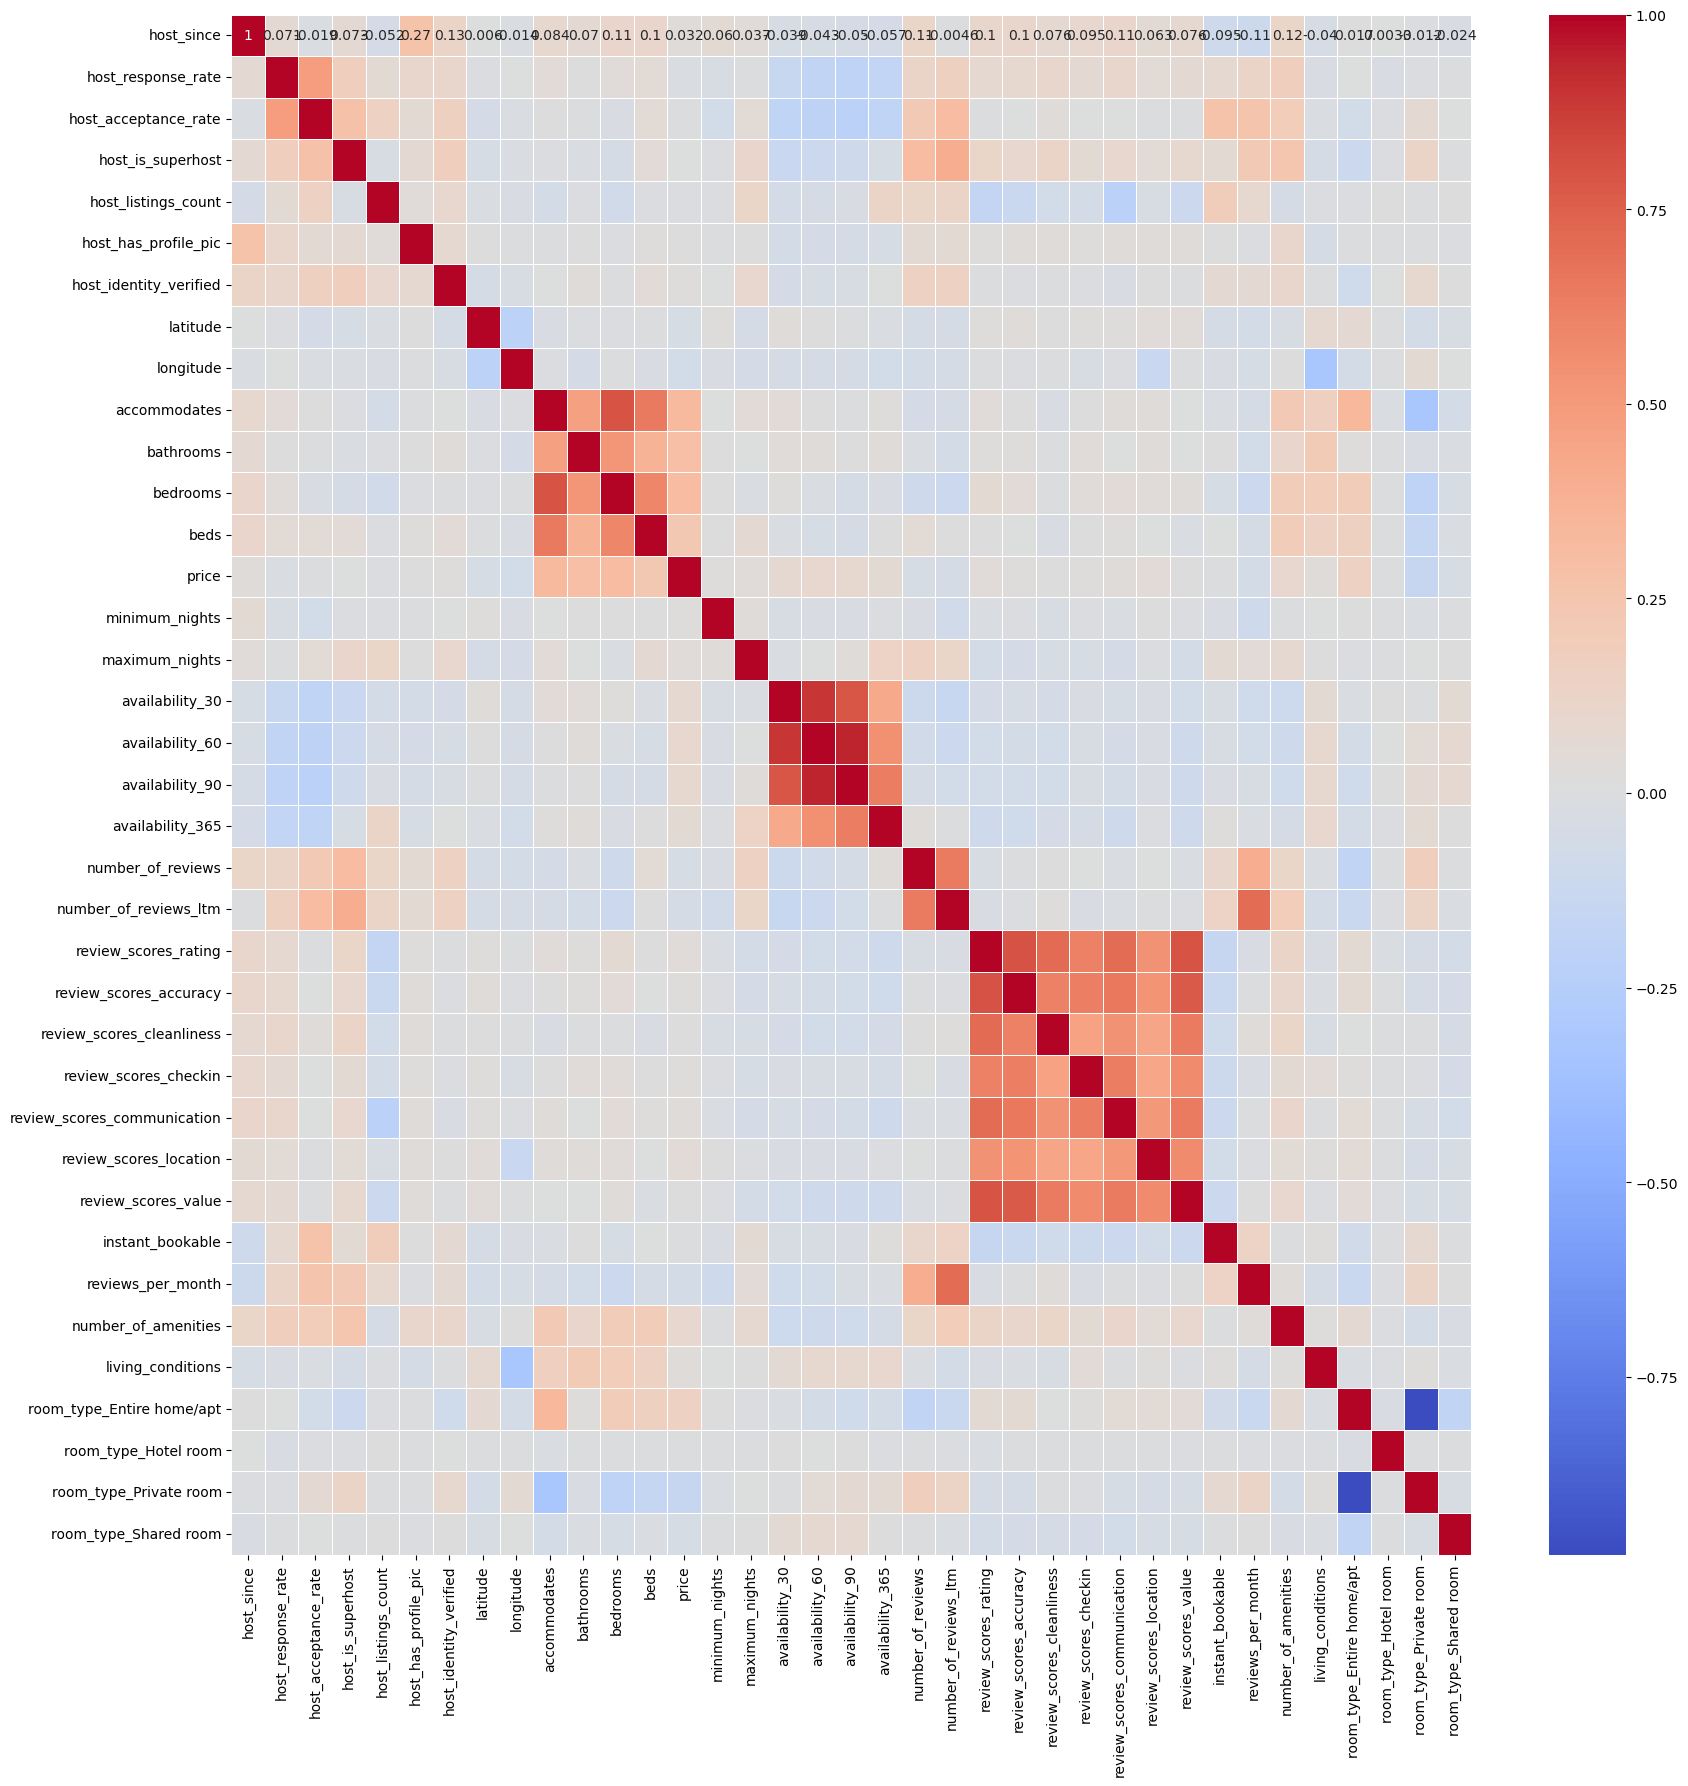

In [163]:
# Plot the correlation matrix
corr = df_cleaned.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm',linewidths=0.5)
plt.show()


2024-11-01 18:08:18.990 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-11-01 18:08:18.997 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2024-11-01 18:08:19.010 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-11-01 18:08:19.092 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-11-01 18:08:19.170 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-11-01 18:08:19.366 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-11-01 18:08:19.389 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-11-01 18:08:20.420 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,1.624630e-08,6303.627816,6324.457551,inf,0.065980,2.019787e-29
expon,3.462935e-08,9182.181613,9196.068103,inf,0.232704,0.000000e+00
cauchy,3.716846e-08,3270.138248,3284.024738,inf,0.121540,5.145116e-99
rayleigh,5.185311e-08,104093.895299,104107.781788,inf,0.276238,0.000000e+00
exponpow,6.362038e-08,23148.186749,23169.016484,inf,0.290583,0.000000e+00


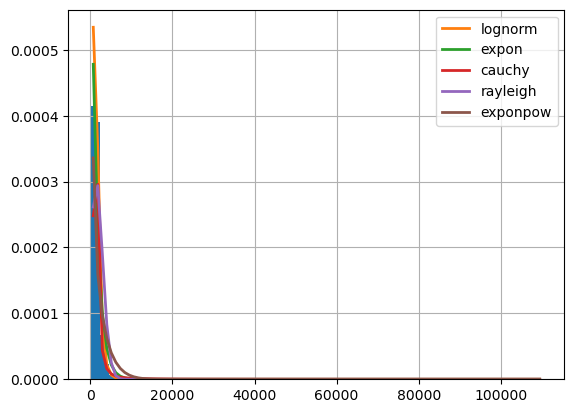

In [164]:
f = Fitter(df_cleaned['price'], distributions=get_common_distributions())
f.fit()
f.summary()

Lognormal is the best fitting distribution, so log-convert price values to be able to remove outliers

In [165]:
def fitting(df, p):
    if p == False:
        return df[df['price']<=6000]
    else:
        df['price'] = np.log(df['price'])

        # Determine the distribution of the 'price' column using Fitter
        f = Fitter(df['price'], distributions=['norm'])
        f.fit()
        f.summary()
        
        # Get the best fitting distribution
        best_dist = f.get_best(method='sumsquare_error')
        best_dist_name = list(best_dist.keys())[0]
        best_dist_params = best_dist['norm']

        mean = best_dist_params['loc']
        std = best_dist_params['scale']
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        
        df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

        df_no_outliers['price'] = np.exp(df_no_outliers['price'])
        return df_no_outliers

2024-11-01 18:08:20.932 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1.806032)
C:\Users\20202894\AppData\Local\Temp\ipykernel_1972\1803394182.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['price'] = np.exp(df_no_outliers['price'])


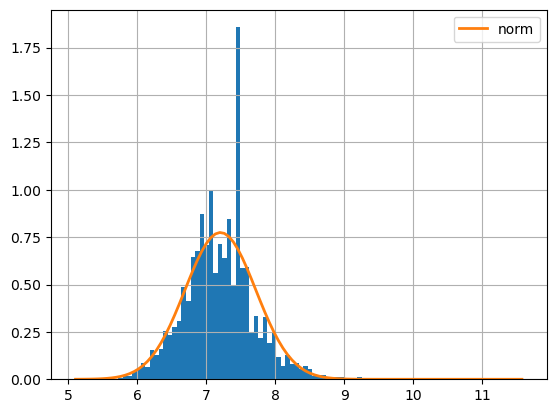

In [166]:
#use previous method p = False, else p = True
p = True

# remove outliers on price column using the normal dist
df_cleaned = fitting(df_cleaned,p)


In [167]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7598 entries, 0 to 10093
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_since                   7598 non-null   int64  
 1   host_response_rate           7598 non-null   float64
 2   host_acceptance_rate         7598 non-null   float64
 3   host_is_superhost            7598 non-null   int64  
 4   host_listings_count          7598 non-null   int64  
 5   host_has_profile_pic         7598 non-null   int64  
 6   host_identity_verified       7598 non-null   int64  
 7   latitude                     7598 non-null   float64
 8   longitude                    7598 non-null   float64
 9   accommodates                 7598 non-null   int64  
 10  bathrooms                    7598 non-null   float64
 11  bedrooms                     7598 non-null   float64
 12  beds                         7598 non-null   float64
 13  price                 

In [168]:
def scale(df):
    scaler = MinMaxScaler()
    columns_to_scale = list(df.columns)
    columns_to_scale.remove('price')

    # Apply MinMaxScaler to the DataFrame
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)

    # Add the 'price' column back to the scaled DataFrame
    df_scaled['price'] = df['price'].values
    return df_scaled

In [169]:
c2 = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "longitude",
    "latitude",
    "host_listings_count",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",   
    "host_is_superhost",
    "price",    
    "living_conditions",   #engineered
    "host_identity_verified",
    "room_type_Entire home/apt", #added back
    "number_of_amenities" #engineered
]
    # "instant_bookable", #removed due to very insignificance
    #   
    # 

In [170]:
df_clean = df_cleaned[c2]

In [171]:
########################################################################################################################################################

#### Feature engineering ideas
1. Distance to tourist things X
2. Distance to city centre Nice
3. Distance to nature X
-----------------------------------------
4. Beds per bedroom X
5. Bathrooms per accommodates X
6. Bedrooms per accommodates X
7. Accommodates per bathroom X
8. Accommodates per bedroom X
----------------------------------------
9. Living conditions per neighbourhood Nice (closer is worse)

But what distance to use:
1. Geodesic

Add (maybe?)
1. room type Entire room/apt (indicating it is a full house and not shared)
2. Number of amenities (get length of list)


In [172]:
oslo_coords = (59.911491, 10.757933)

#Geodesic distance:
df_clean['distance_to_oslo_s'] = df_clean.apply(lambda row: geodesic((row['latitude'], row['longitude']), oslo_coords).meters, axis=1)

C:\Users\20202894\AppData\Local\Temp\ipykernel_1972\887749612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['distance_to_oslo_s'] = df_clean.apply(lambda row: geodesic((row['latitude'], row['longitude']), oslo_coords).meters, axis=1)


In [173]:
########################################################################################################################################################

In [174]:
df_clean = scale(df_clean)

In [175]:
df_clean.head()

,accommodates,bathrooms,bedrooms,longitude,latitude,host_listings_count,minimum_nights,number_of_reviews,reviews_per_month,host_is_superhost,living_conditions,host_identity_verified,room_type_Entire home/apt,number_of_amenities,distance_to_oslo_s,price
0,0.133333,0.2,0.333333,0.304789,0.422422,0.007692,0.008310,0.044789,0.028788,1.0,0.591549,1.0,1.0,0.393474,0.119898,3400.0
1,0.066667,0.2,0.166667,0.482331,0.404321,0.000000,0.036011,0.048234,0.025000,0.0,0.000000,1.0,0.0,0.500960,0.080306,572.0
2,0.200000,0.2,0.333333,0.458100,0.416760,0.015385,0.005540,0.068045,0.037121,1.0,0.000000,1.0,1.0,0.462572,0.047505,1929.0
3,0.066667,0.2,0.166667,0.457234,0.424740,0.015385,0.000000,0.202412,0.111364,1.0,0.000000,1.0,0.0,0.330614,0.046752,736.0
4,0.066667,0.2,0.166667,0.379631,0.475787,0.007692,0.011080,0.037037,0.019697,0.0,0.422535,1.0,0.0,0.224088,0.094773,1029.0


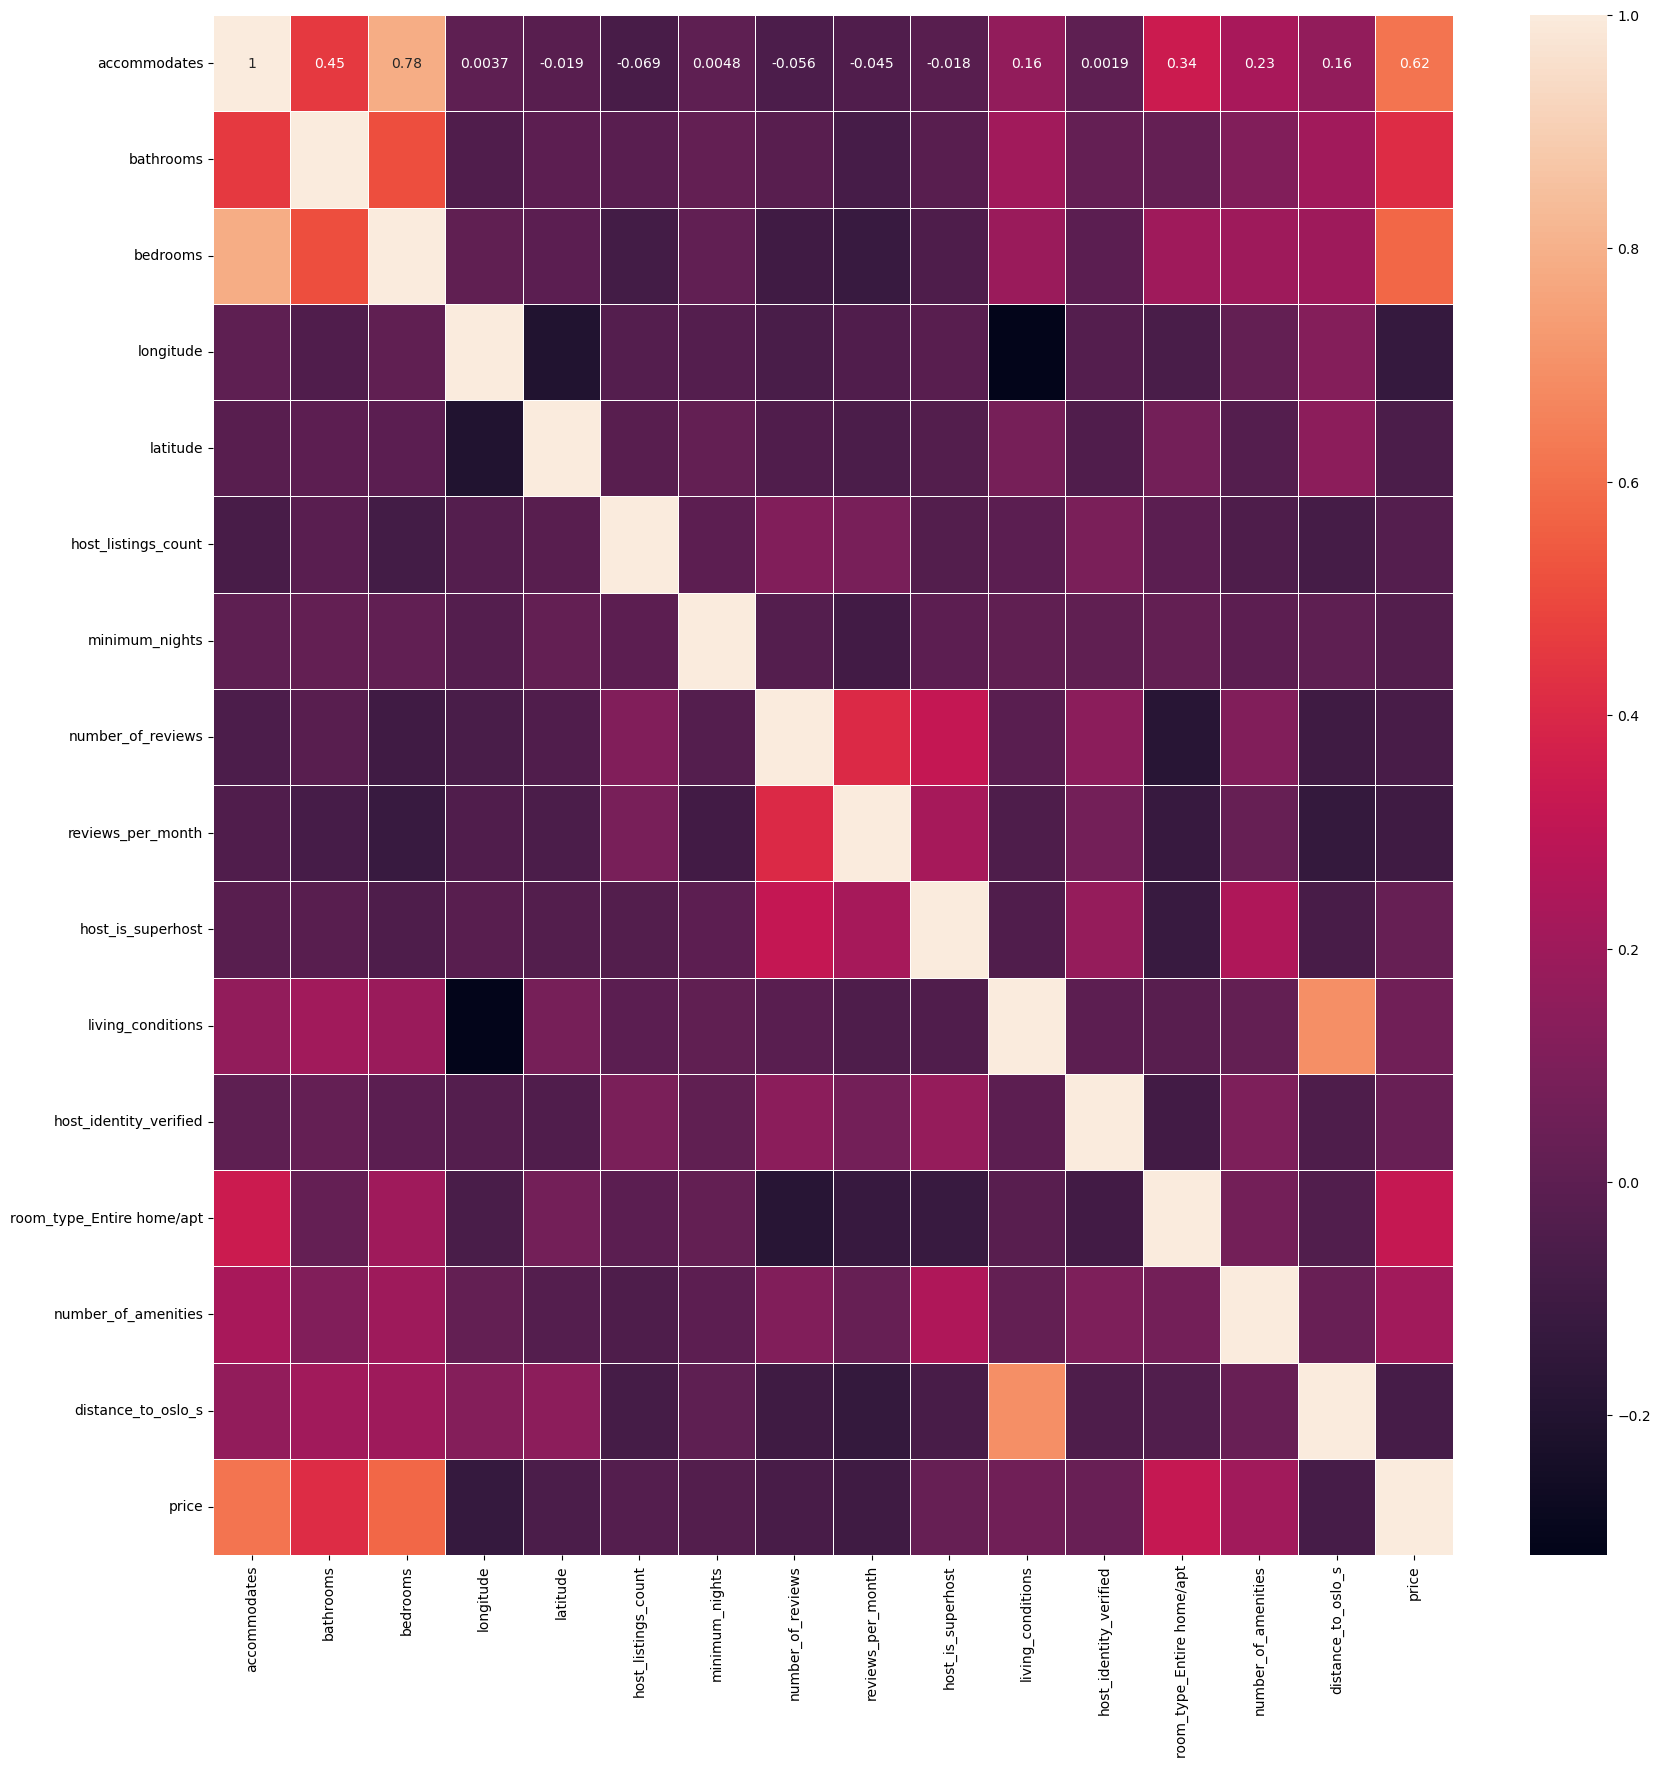

In [176]:
# Plot the correlation matrix
corr = df_clean.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, linewidths=0.5)
plt.show()


In [177]:
X = df_clean.drop('price', axis=1).copy()
y = df_clean['price'].copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [178]:
# Add constant term for intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the OLS model using statsmodels
ols_model_sm = sm.OLS(y_train, X_train_sm).fit()

# Make predictions
ols_predictions_sm = ols_model_sm.predict(X_test_sm)

# Calculate metrics
ols_mse_sm = mean_squared_error(y_test, ols_predictions_sm)
ols_rmse_sm = np.sqrt(ols_mse_sm)
ols_r2_sm = r2_score(y_test, ols_predictions_sm)

# Print the summary of the model
print(ols_model_sm.summary())

# Print the calculated metrics
print(f"R²: {ols_r2_sm}")
print(f"RMSE: {ols_rmse_sm}")


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     410.8
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:08:22   Log-Likelihood:                -47123.
No. Observations:                6078   AIC:                         9.428e+04
Df Residuals:                    6062   BIC:                         9.439e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

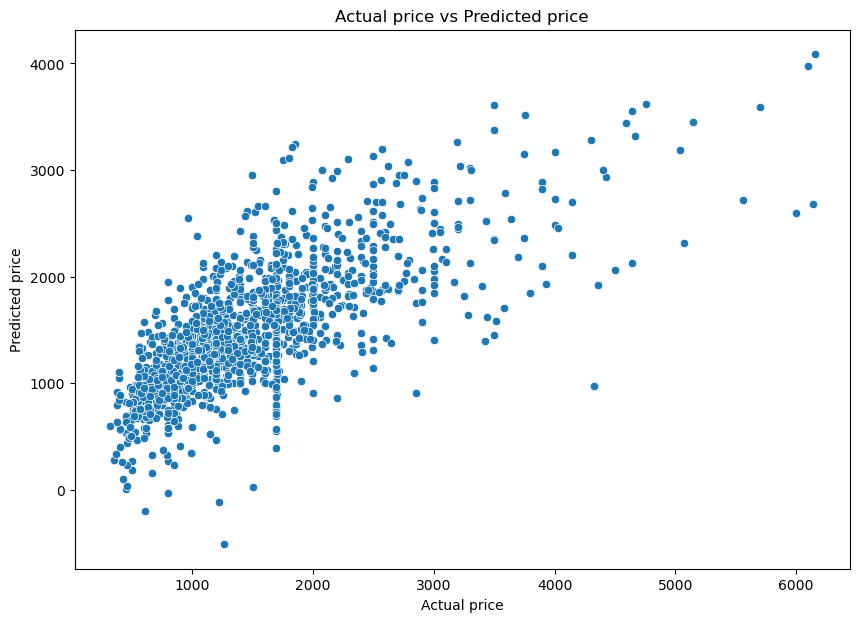

In [179]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=ols_predictions_sm)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual price vs Predicted price')
plt.show()

In [180]:
# Initialize and fit RFE with Random Forest
rf_model = RandomForestRegressor(n_estimators=1000, random_state=SEED)

# Train and evaluate Random Forest model
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [181]:
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = round(r2_score(y_test, rf_predictions),3)
print(f'Random Forest Model - R²: {rf_r2}, RMSE: {rf_rmse}')

Random Forest Model - R²: 0.601, RMSE: 493.7642003697732


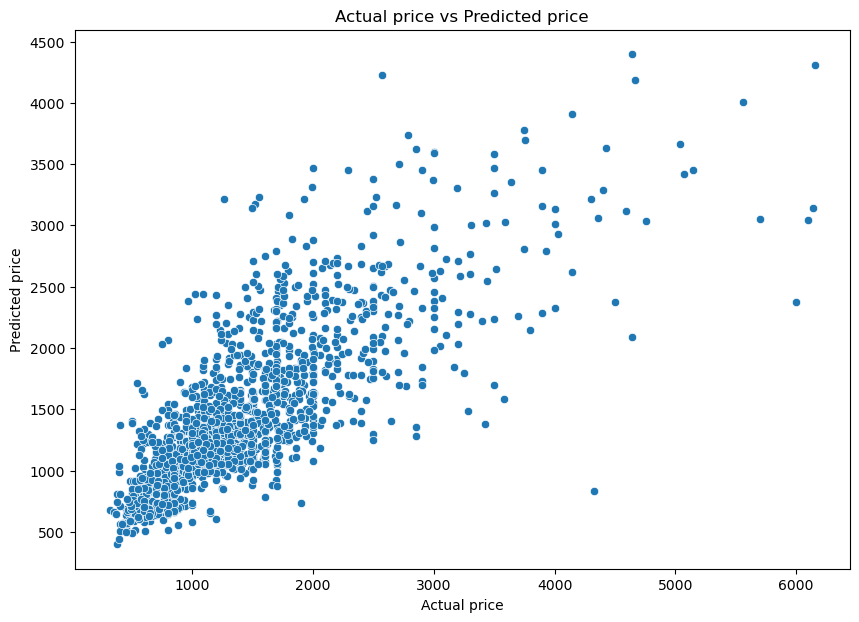

In [182]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=rf_predictions)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual price vs Predicted price')
plt.show()

In [183]:
# import pickle

# # Save the model to a file
# with open('random_forest_model.pkl', 'wb') as file:
#     pickle.dump(rf_model, file)


In [184]:
# # Load the model from the file
# with open('random_forest_model.pkl', 'rb') as file:
#     loaded_rf_model = pickle.load(file)

# # Use the loaded model to make predictions
# loaded_rf_predictions = loaded_rf_model.predict(X_test)


In [185]:
# rf_predictions = loaded_rf_model.predict(X_test)
# rf_mse = mean_squared_error(y_test, rf_predictions)
# rf_rmse = np.sqrt(rf_mse)
# rf_r2 = round(r2_score(y_test, rf_predictions),3)
# print(f'Random Forest Model - R²: {rf_r2}, RMSE: {rf_rmse}')

Random Forest Model - R²: 0.601, RMSE: 493.7642003697732
